In [18]:
from epitope_data import EpitopeDataVdjDB
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import scipy.stats as ss
plt.style.use('ggplot')
sns.set_style("whitegrid")

In [2]:
# here I just add a row for TRB with NLV
data = pd.read_csv('Gee2018_VDJdb.csv')

In [3]:
rows = {'antigen.epitope': 'NLVPMVATV', 'cdr3.beta': 'CASSLAPGATNEKLFF', 'mhc.a': 'HLA-A*02:01', 
        'species': 'HomoSapiens'}

In [4]:
data.dropna(subset=['cdr3.alpha', 'cdr3.beta']).append(rows, ignore_index=True).to_csv('added_trb_nlv.csv', 
                                                                                       index=False)

In [5]:
# alpha chain
chain = 'TRA'
duplicates_alpha = EpitopeDataVdjDB(chain=chain, folder='.', file='Gee2018_VDJdb.csv', duplicate=True, 
                                    prediction_path=f'prediction_duplicates_Gee2018_VDJdb_{chain}.csv', 
                                    predict=True, duplicate_name='Gee2018_VDJdb')

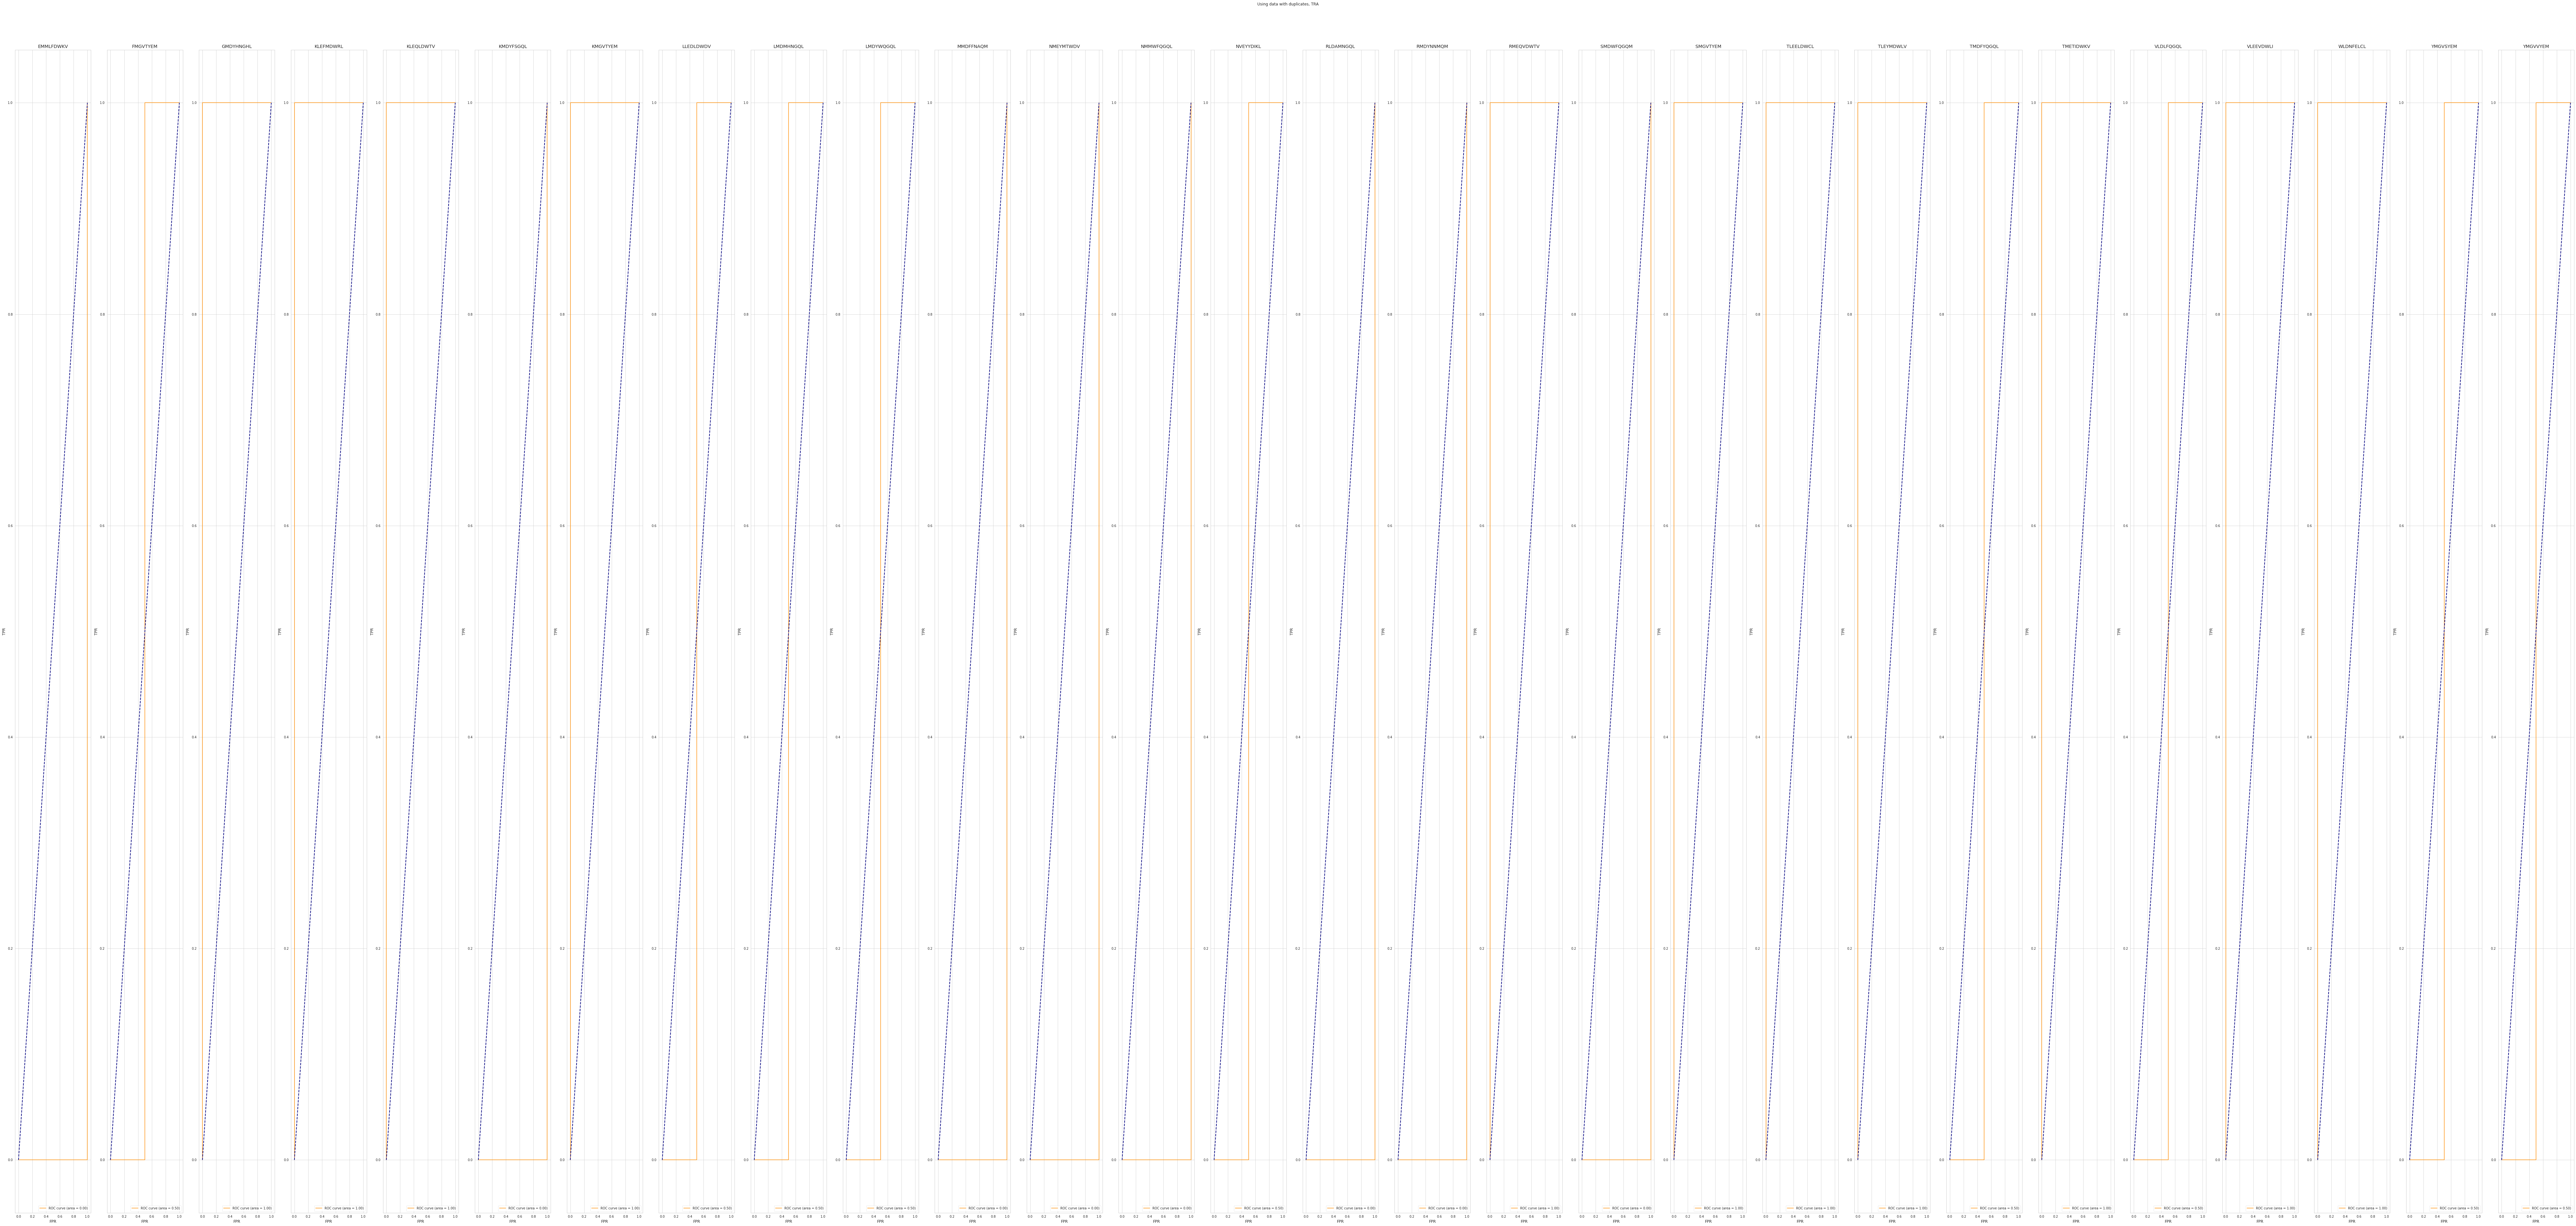

In [6]:
duplicates_alpha.roc()

In [7]:
tra_data = duplicates_alpha.data

In [8]:
# beta chain
chain = 'TRB'
duplicates_beta = EpitopeDataVdjDB(chain=chain, folder='.', file='added_trb_nlv.csv', duplicate=True, 
                                   prediction_path=f'prediction_duplicates_added_trb_nlv_{chain}.csv', 
                                   predict=True, duplicate_name='added_trb_nlv')

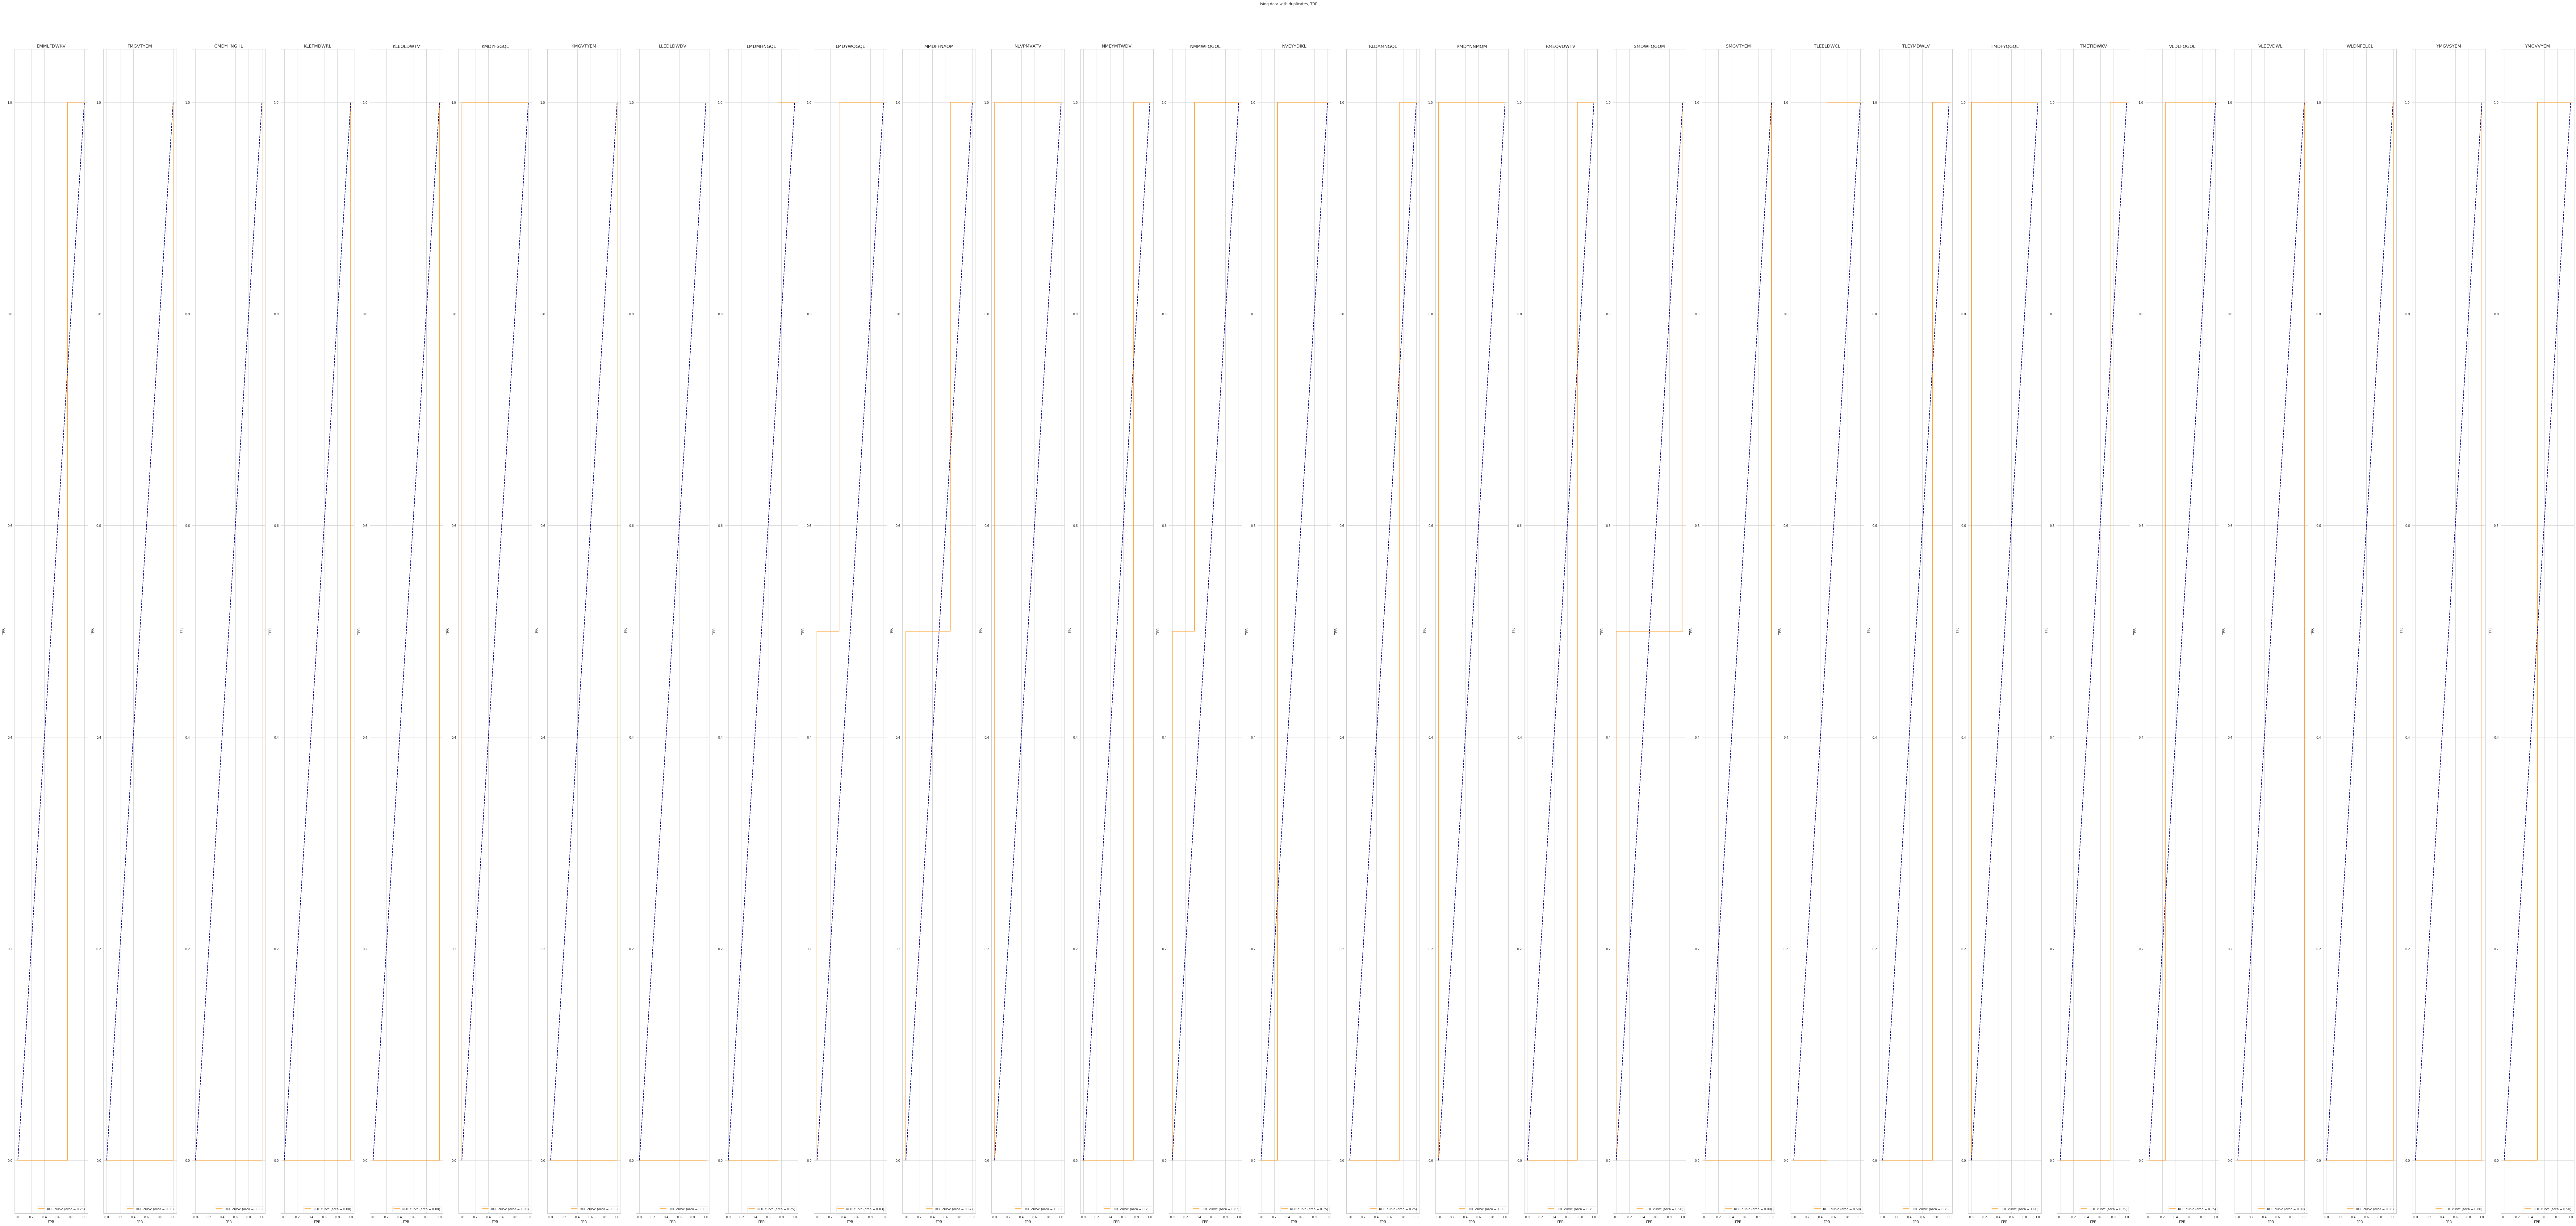

In [9]:
duplicates_beta.roc()

In [10]:
trb_data = duplicates_beta.data

In [11]:
nlv_data = trb_data.loc[trb_data.Antigen == 'NLVPMVATV']

In [12]:
tra_data['Label'] = tra_data.label.apply(lambda x: 'Real' if x == 1 else 'Substituted')
trb_data['Label'] = trb_data.label.apply(lambda x: 'Real' if x == 1 else 'Substituted')
nlv_data['Label'] = nlv_data.label.apply(lambda x: 'Real' if x == 1 else 'Substituted')

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


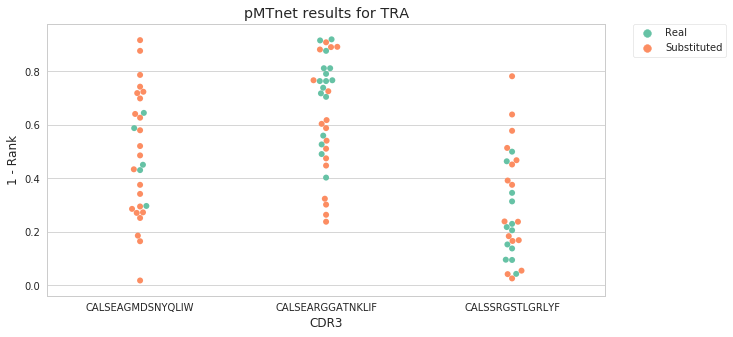

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.swarmplot(x="CDR3", y="Rank", hue='Label', data=tra_data, size=6, 
                   palette=sns.color_palette("Set2", 10))

ax.set_ylabel('1 - Rank')
ax.set_title('pMTnet results for TRA')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

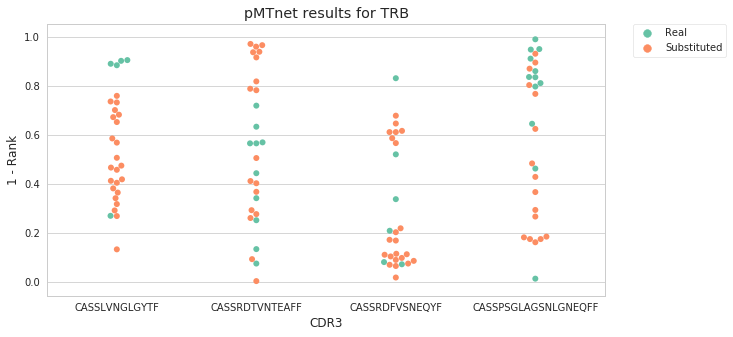

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.swarmplot(x="CDR3", y="Rank", hue='Label', 
                   data=trb_data.loc[(trb_data.CDR3 != 'CASSLAPGATNEKLFF') & (trb_data.Antigen != 'NLVPMVATV')],
                   size=6, palette=sns.color_palette("Set2"))

ax.set_ylabel('1 - Rank')
ax.set_title('pMTnet results for TRB')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

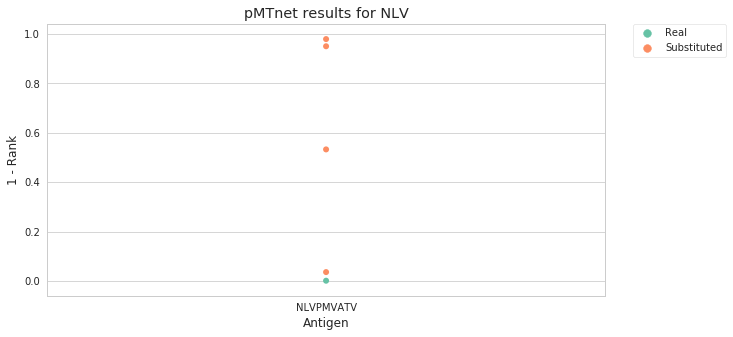

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.swarmplot(x="Antigen", y="Rank", hue='Label', data=nlv_data, size=6, palette=sns.color_palette("Set2"))

ax.set_ylabel('1 - Rank')
ax.set_title('pMTnet results for NLV')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## t-tests

In [ ]:
# here we test H0: m1 == m2
#              H1: m1 != m2

In [51]:
def t_test(t_data, groupby='CDR3', group=True, overall=False):
    if group:
        for cdr, data in t_data.groupby('CDR3'):
            cdr_true = data.loc[data.label == 1].Rank.values
            cdr_false = data.loc[data.label != 1].Rank.values
            print(f'{cdr}: t-test p-value = {ss.ttest_ind(cdr_true, cdr_false).pvalue:.4f}')
    
    if overall:
        cdr_true = t_data.loc[t_data.label == 1].Rank.values
        cdr_false = t_data.loc[t_data.label != 1].Rank.values
        print(f'\nOverall {cdr}: t-test p-value = {ss.ttest_ind(cdr_true, cdr_false).pvalue:.4f}')

In [53]:
# t-test for TRA
t_test(tra_data, overall=True)

CALSEAGMDSNYQLIW: t-test p-value = 0.9635
CALSEARGGATNKLIF: t-test p-value = 0.0557
CALSSRGSTLGRLYF: t-test p-value = 0.2005

Overall CALSSRGSTLGRLYF: t-test p-value = 0.5404


In [55]:
# t-test for TRB
t_test(trb_data.loc[(trb_data.CDR3 != 'CASSLAPGATNEKLFF') & (trb_data.Antigen != 'NLVPMVATV')], overall=True)

CASSLVNGLGYTF: t-test p-value = 0.0074
CASSPSGLAGSNLGNEQFF: t-test p-value = 0.0167
CASSRDFVSNEQYF: t-test p-value = 0.5669
CASSRDTVNTEAFF: t-test p-value = 0.1776

Overall CASSRDTVNTEAFF: t-test p-value = 0.0307


## Kolmogorov-Smirnov

In [ ]:
# here we test H0: F1 == F2
#              H1: F1 != F2

In [44]:
def ks_test(ks_data, groupby='CDR3', group=True, overall=False):
    if group:
        for cdr, data in ks_data.groupby('CDR3'):
            cdr_true = data.loc[data.label == 1].Rank.values
            cdr_false = data.loc[data.label != 1].Rank.values
            print(f'{cdr}: KS p-value = {ss.ks_2samp(cdr_true, cdr_false).pvalue:.4f}')

    if overall:
        cdr_true = ks_data.loc[ks_data.label == 1].Rank.values
        cdr_false = ks_data.loc[ks_data.label != 1].Rank.values
        print(f'\nOverall {cdr}: KS p-value = {ss.ks_2samp(cdr_true, cdr_false).pvalue:.4f}')

In [48]:
# KS test for TRA
ks_test(tra_data, overall=True)

CALSEAGMDSNYQLIW: KS p-value = 0.5989
CALSEARGGATNKLIF: KS p-value = 0.1068
CALSSRGSTLGRLYF: KS p-value = 0.3644

Overall CALSSRGSTLGRLYF: KS p-value = 0.7150


In [50]:
# KS test for TRB
ks_test(trb_data.loc[(trb_data.CDR3 != 'CASSLAPGATNEKLFF') & (trb_data.Antigen != 'NLVPMVATV')], overall=True)

CASSLVNGLGYTF: KS p-value = 0.0030
CASSPSGLAGSNLGNEQFF: KS p-value = 0.0336
CASSRDFVSNEQYF: KS p-value = 0.6766
CASSRDTVNTEAFF: KS p-value = 0.0548

Overall CASSRDTVNTEAFF: KS p-value = 0.0350
